In [2]:
#Influence of dirac position on Radon transform


import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import radon

#image = imread(data_dir + "/phantom.png", as_gray=True)
#image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
image = np.zeros((64, 64))

theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(8, 8, figsize=(30,30), dpi=150)


for i in range(0, 63, 8):
    for j in range(0, 63, 8):
        image = image = np.zeros((64, 64)); image[i][j] = 1;
        
        sinogram = radon(image, theta=theta, circle=True)
        axs[i//8, j//8].imshow(sinogram, cmap=plt.cm.Greys_r,
               extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

plt.show()

c:\users\romain\appdata\local\programs\python\python37\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


<Figure size 4500x4500 with 64 Axes>

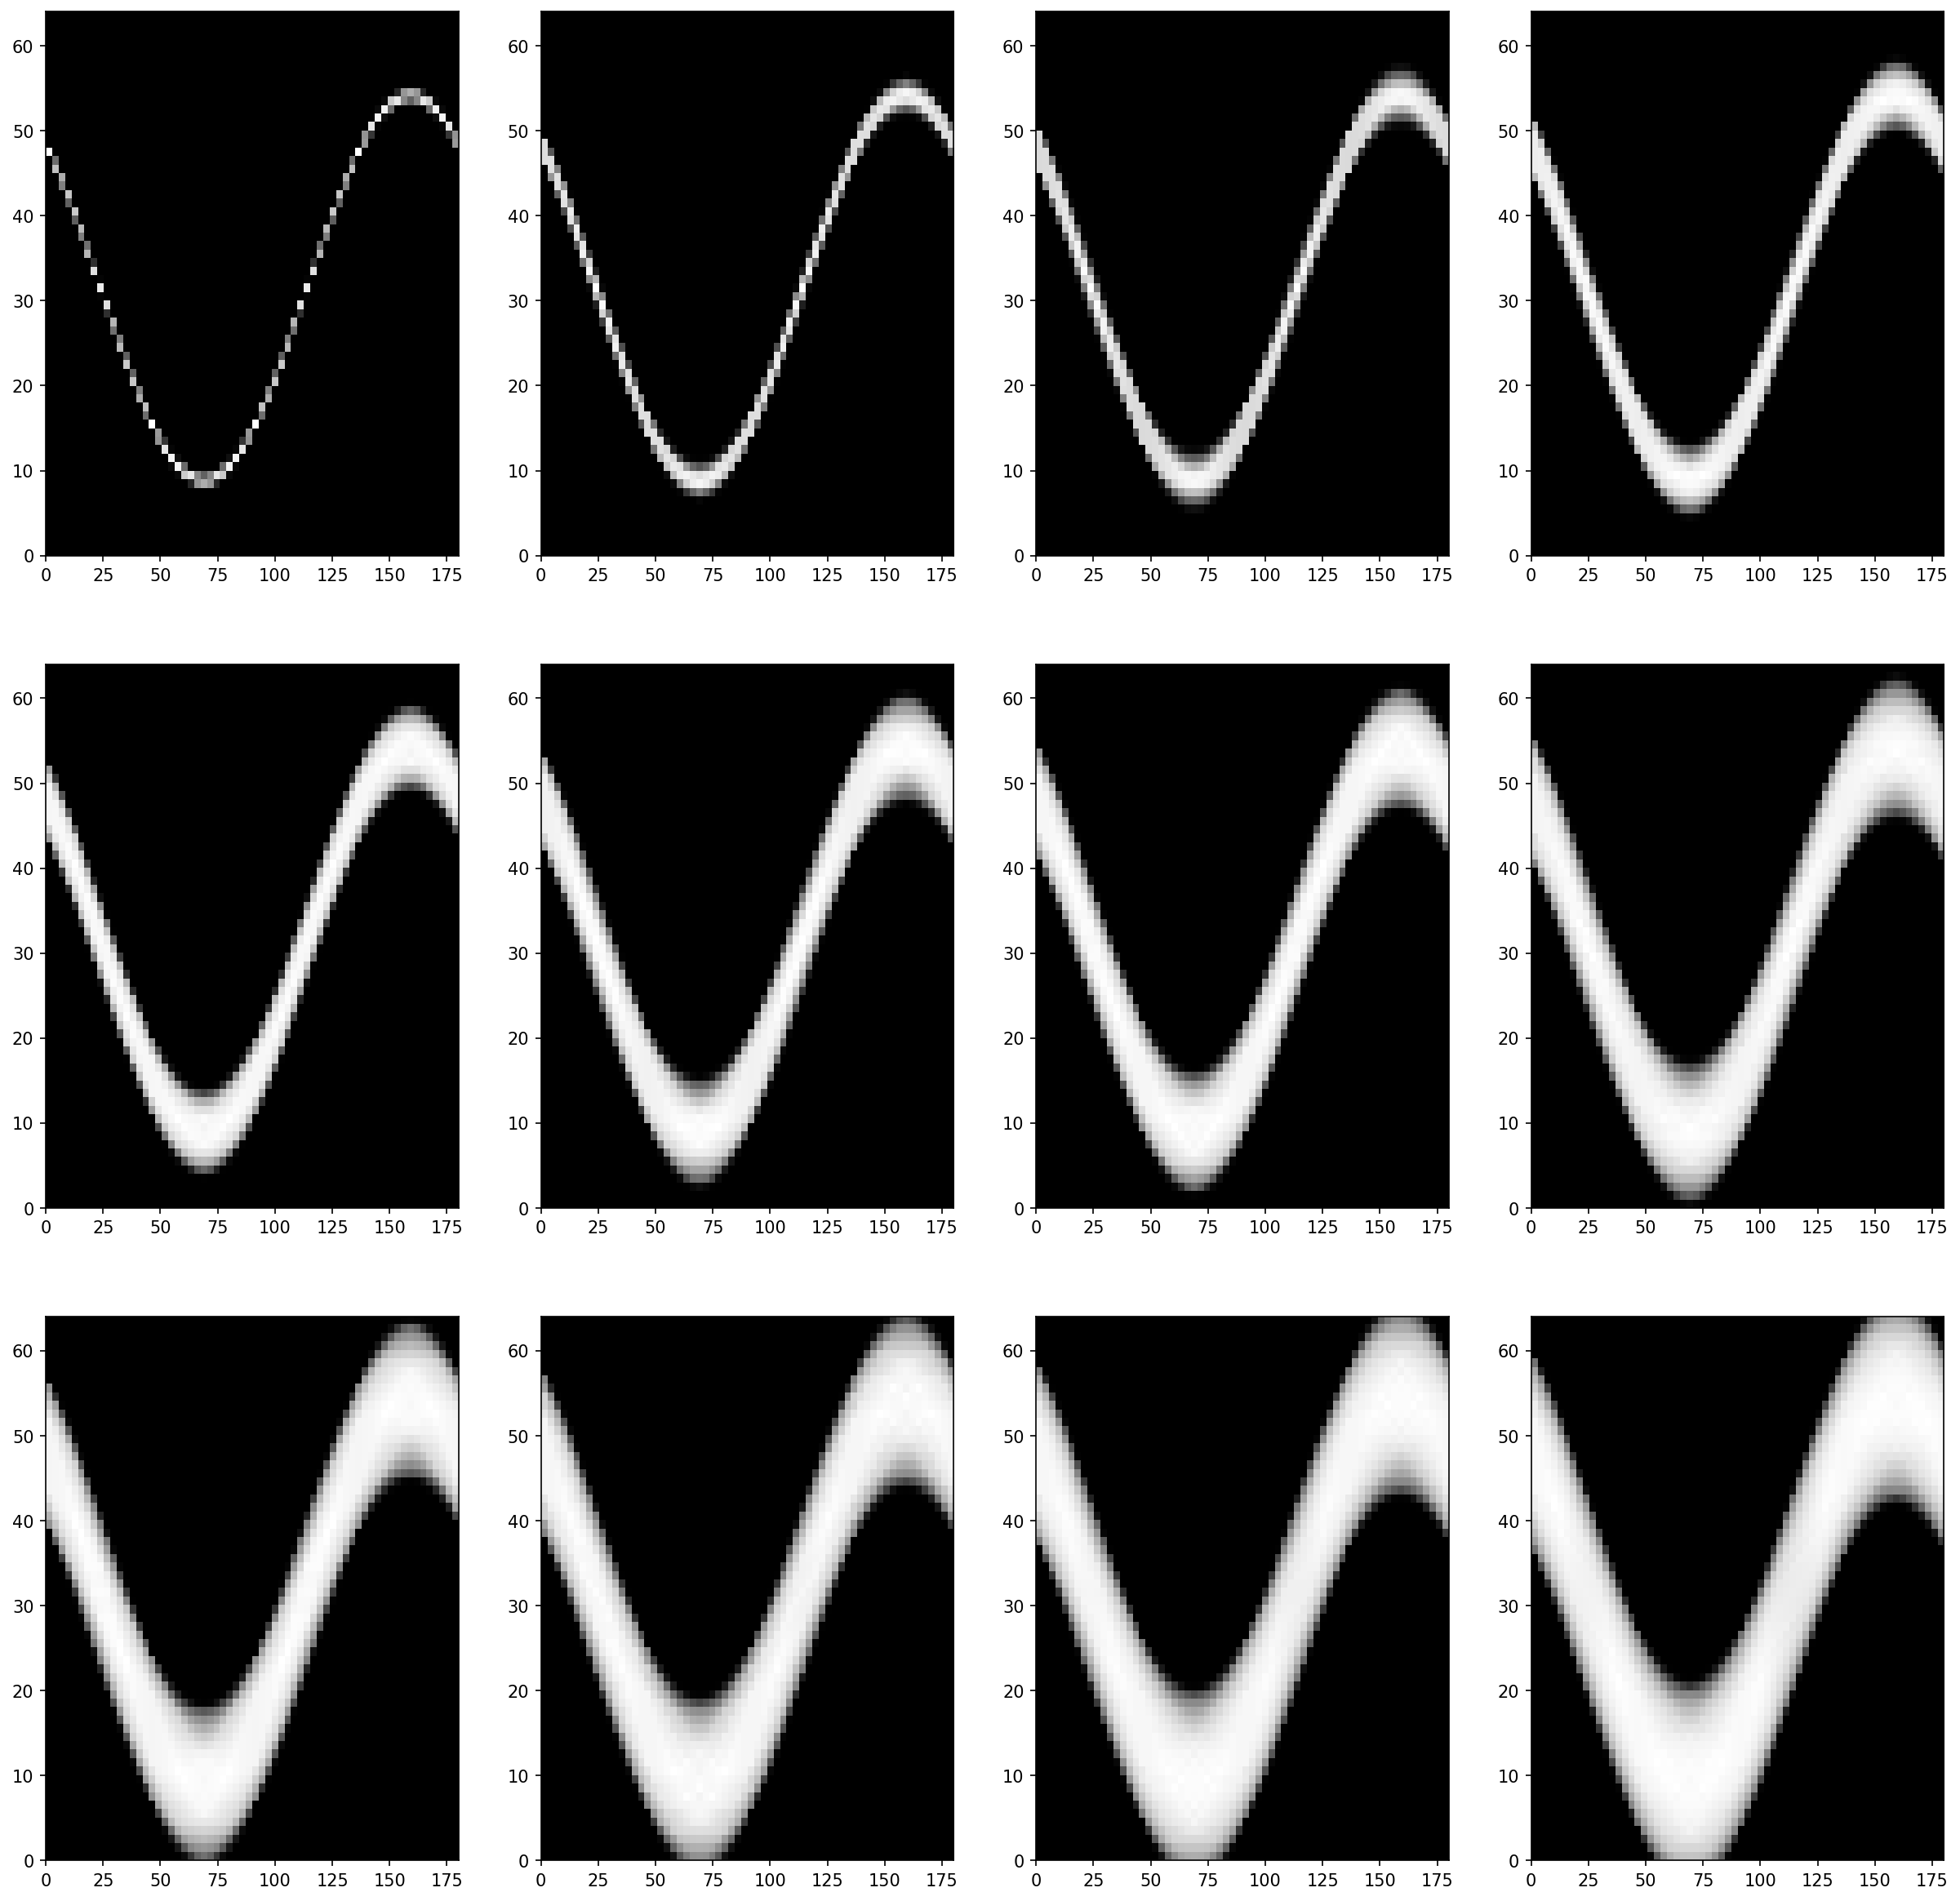

In [17]:
#Influence of size of a circle on radon transform
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import radon
from skimage.draw import circle


image = np.zeros((64,64))
theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(3, 4, figsize=(20,20), dpi=150)

pos_x, pos_y = 16, 16
for r in range (1,13):
    image = np.zeros((64,64))
    rr, cc = circle(pos_x, pos_y, r)
    image[rr, cc] = 1
    
    sinogram = radon(image, theta=theta, circle=True)
    axs[(r-1)//4, (r-1)%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
plt.show()

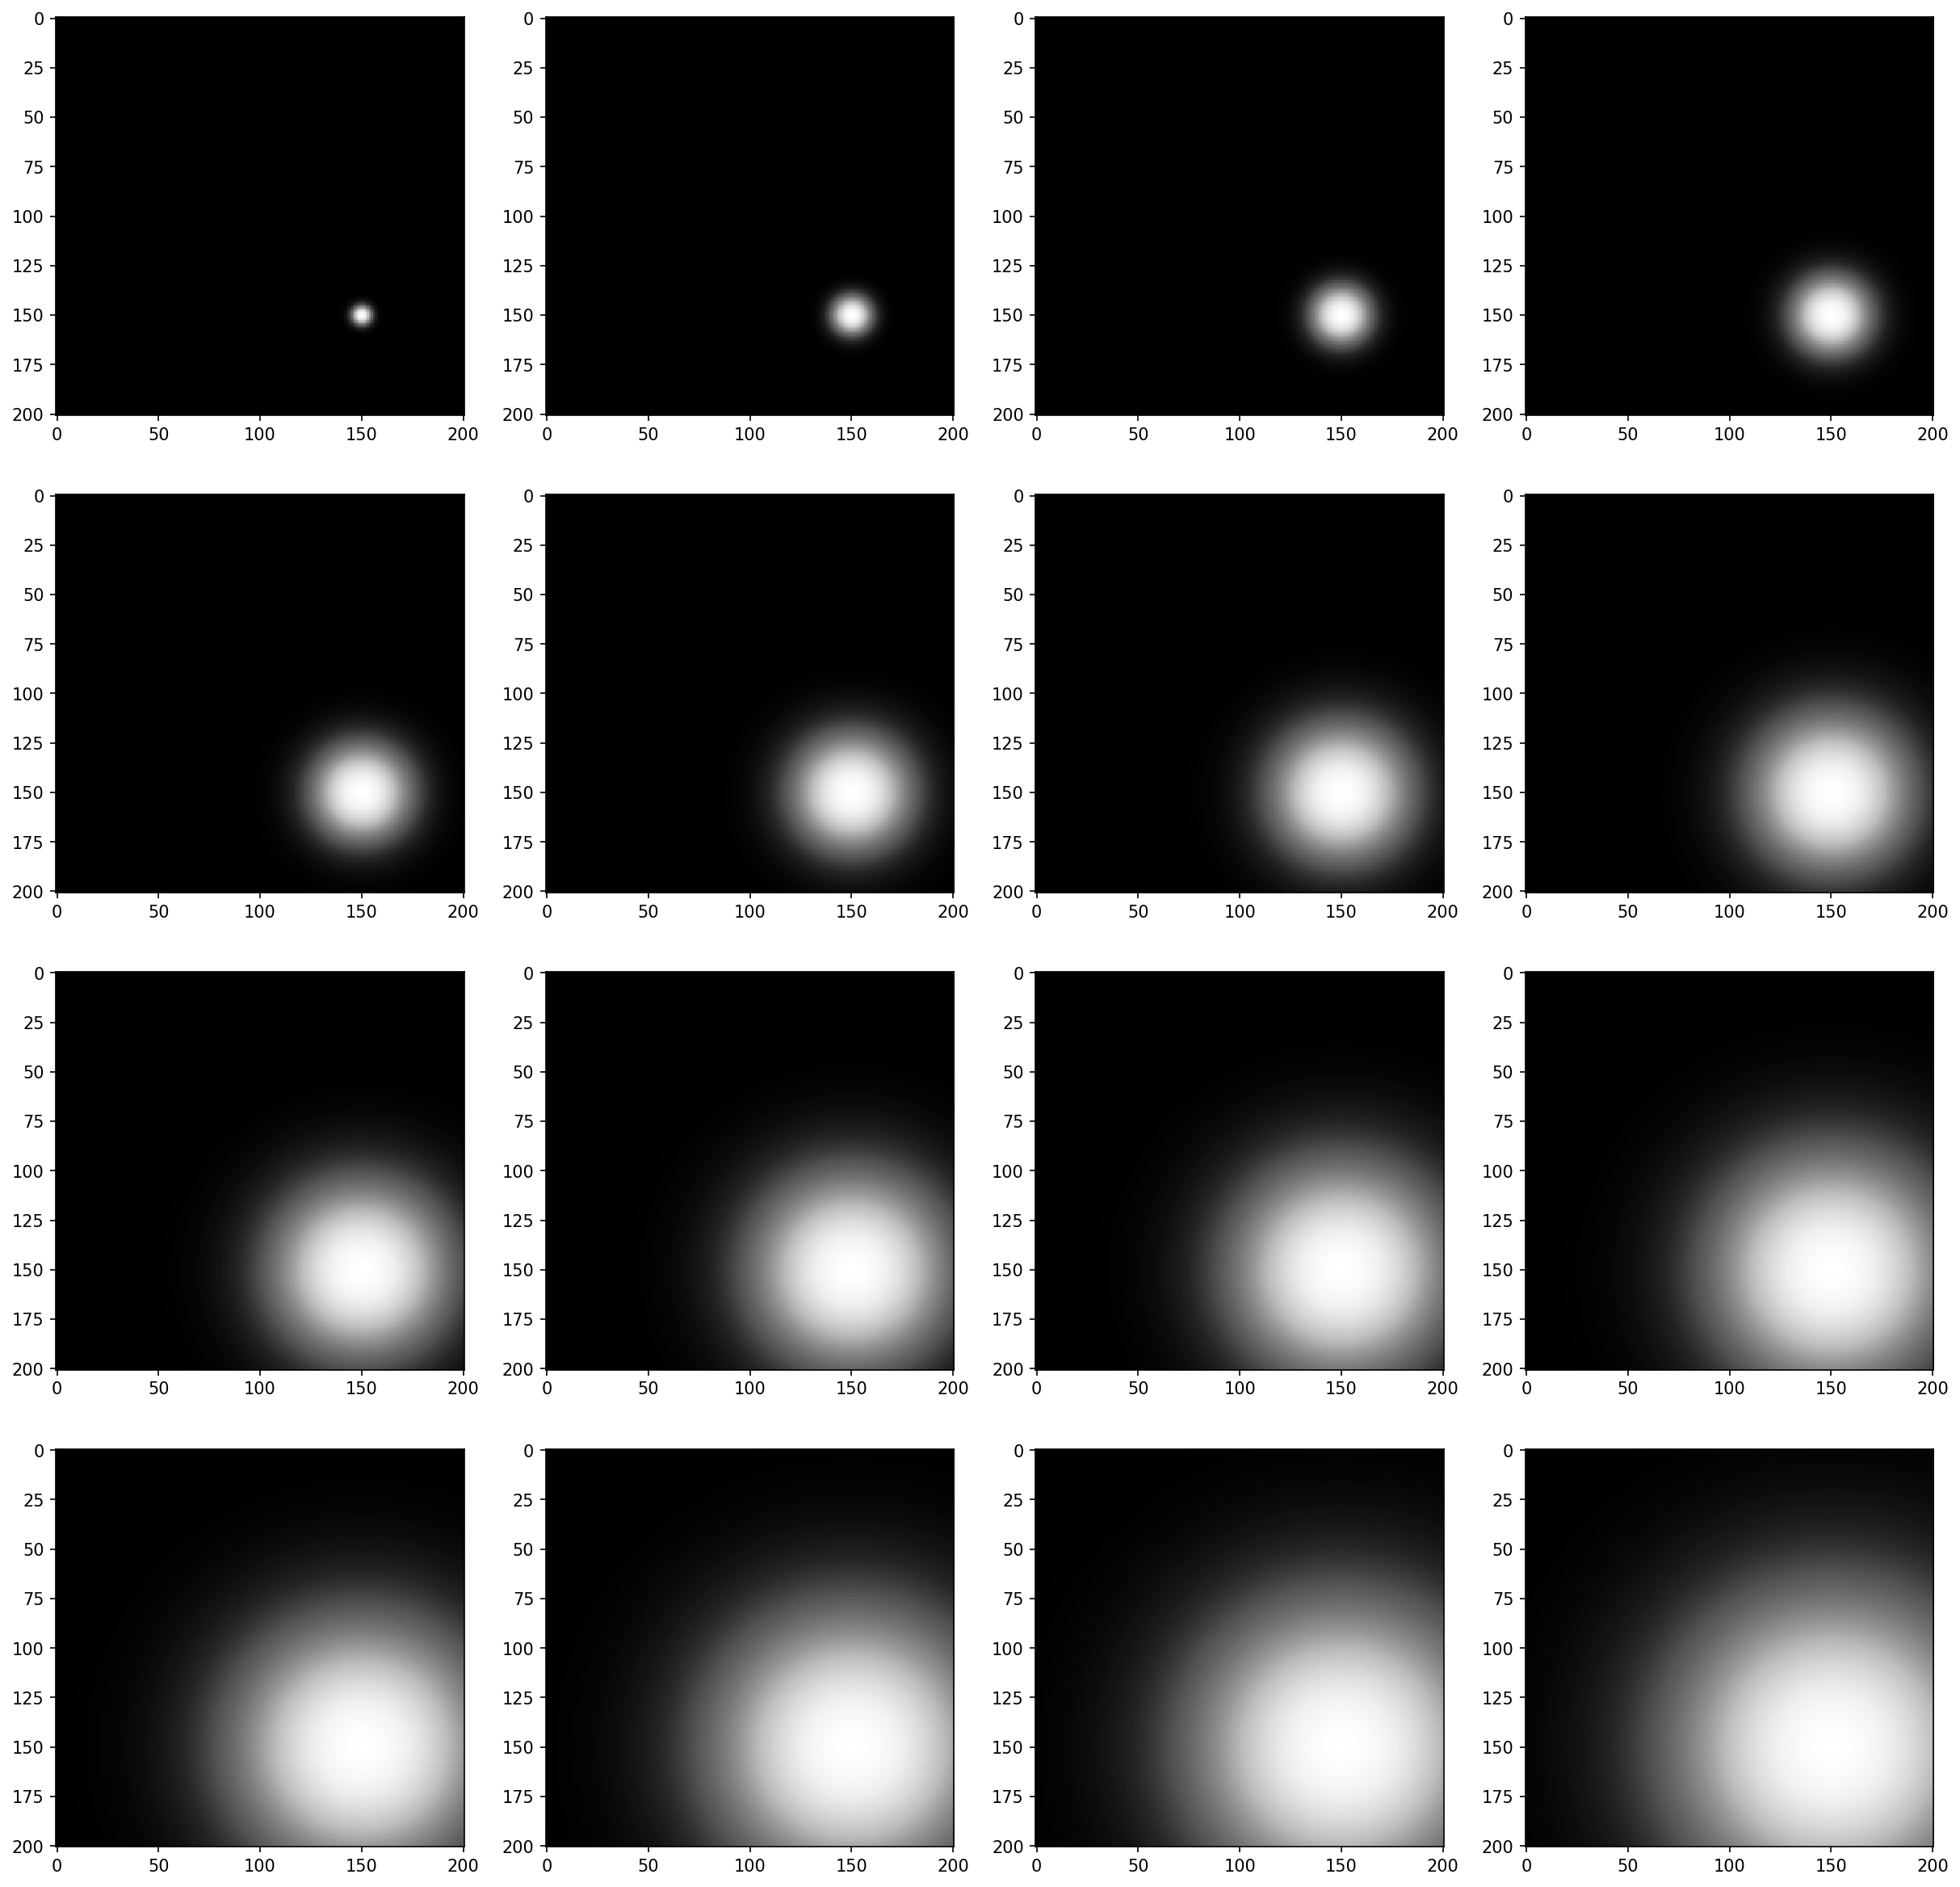

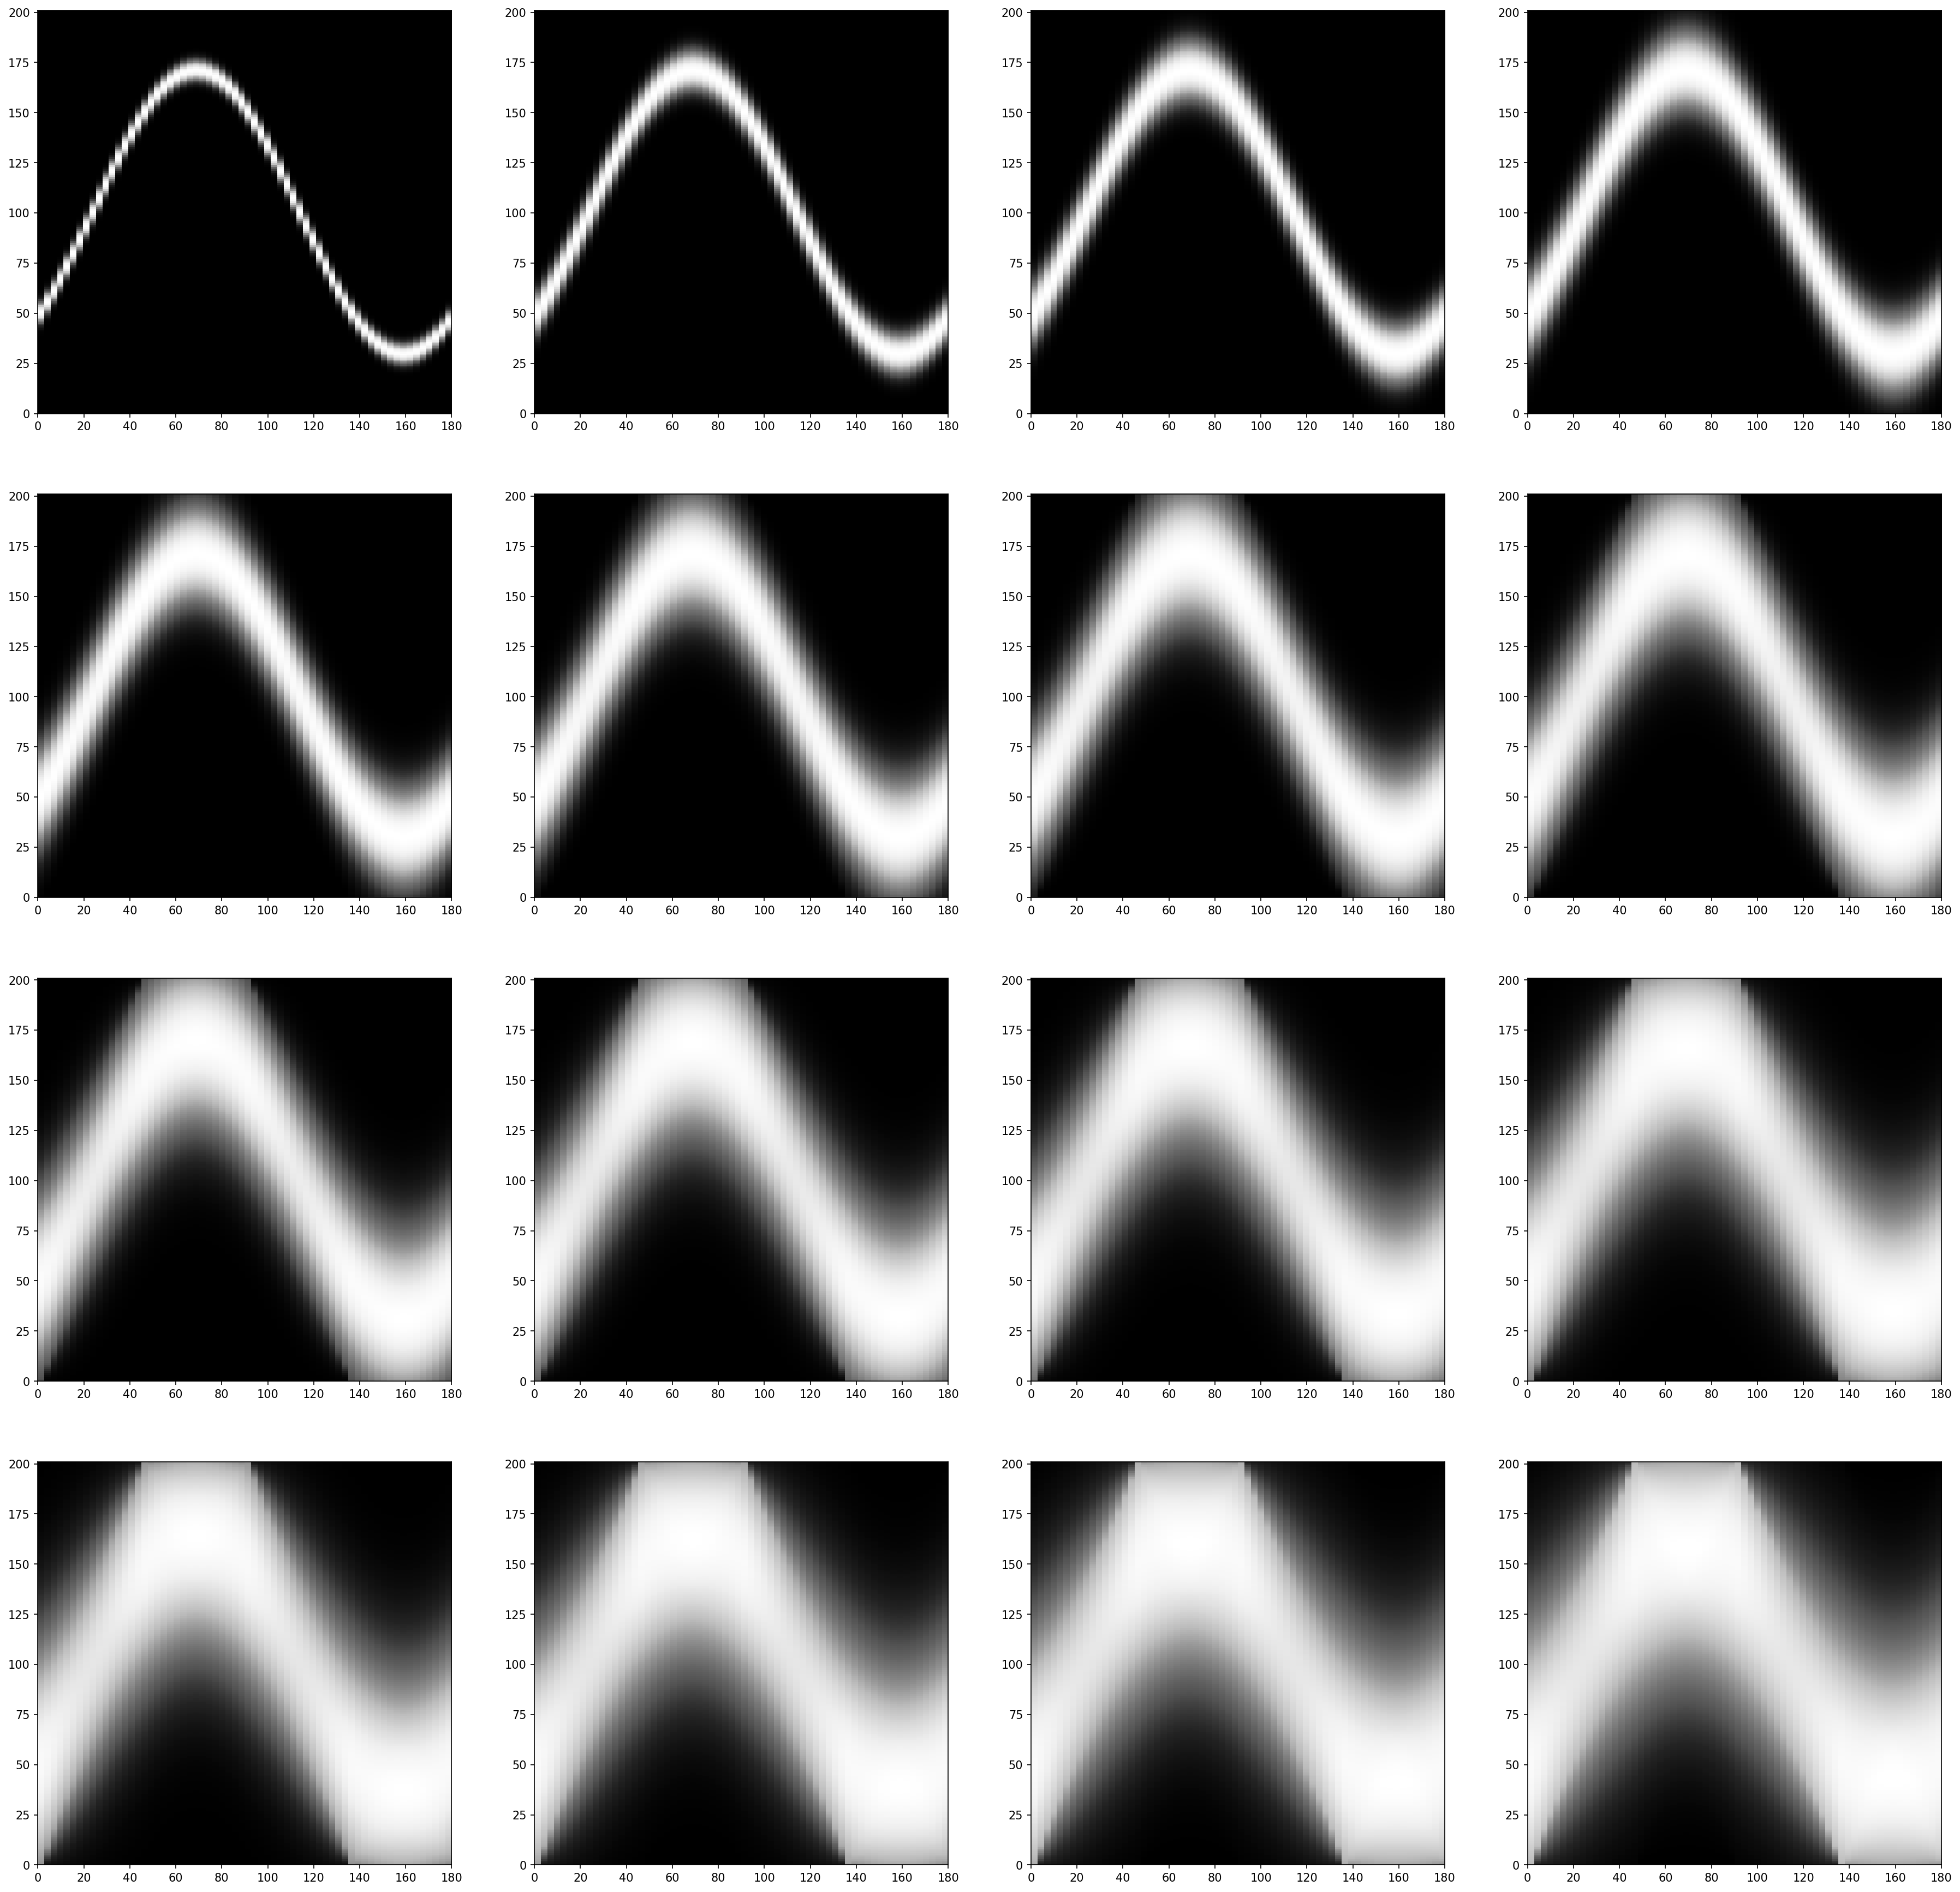

In [18]:
theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(4, 4, figsize=(20,20), dpi=150)
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30), dpi=150)
pos_x, pos_y = 5, 5

for r in range (1, 17):
    sig_x, sig_y = 20,20
    sig = r*r / 9
    
    x = np.linspace(-10, 10, 201)
    y = np.linspace(-10, 10, 201)
    X,Y = np.meshgrid(x,y)
    
    image = np.exp(- ((X-pos_x)*(X-pos_x) + (Y-pos_y)*(Y-pos_y)) /(2*sig))
    axs[(r-1)//4, (r-1)%4].imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    
    sinogram = radon(image, theta=theta, circle=True)
    axs2[(r-1)//4, (r-1)%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
plt.show()



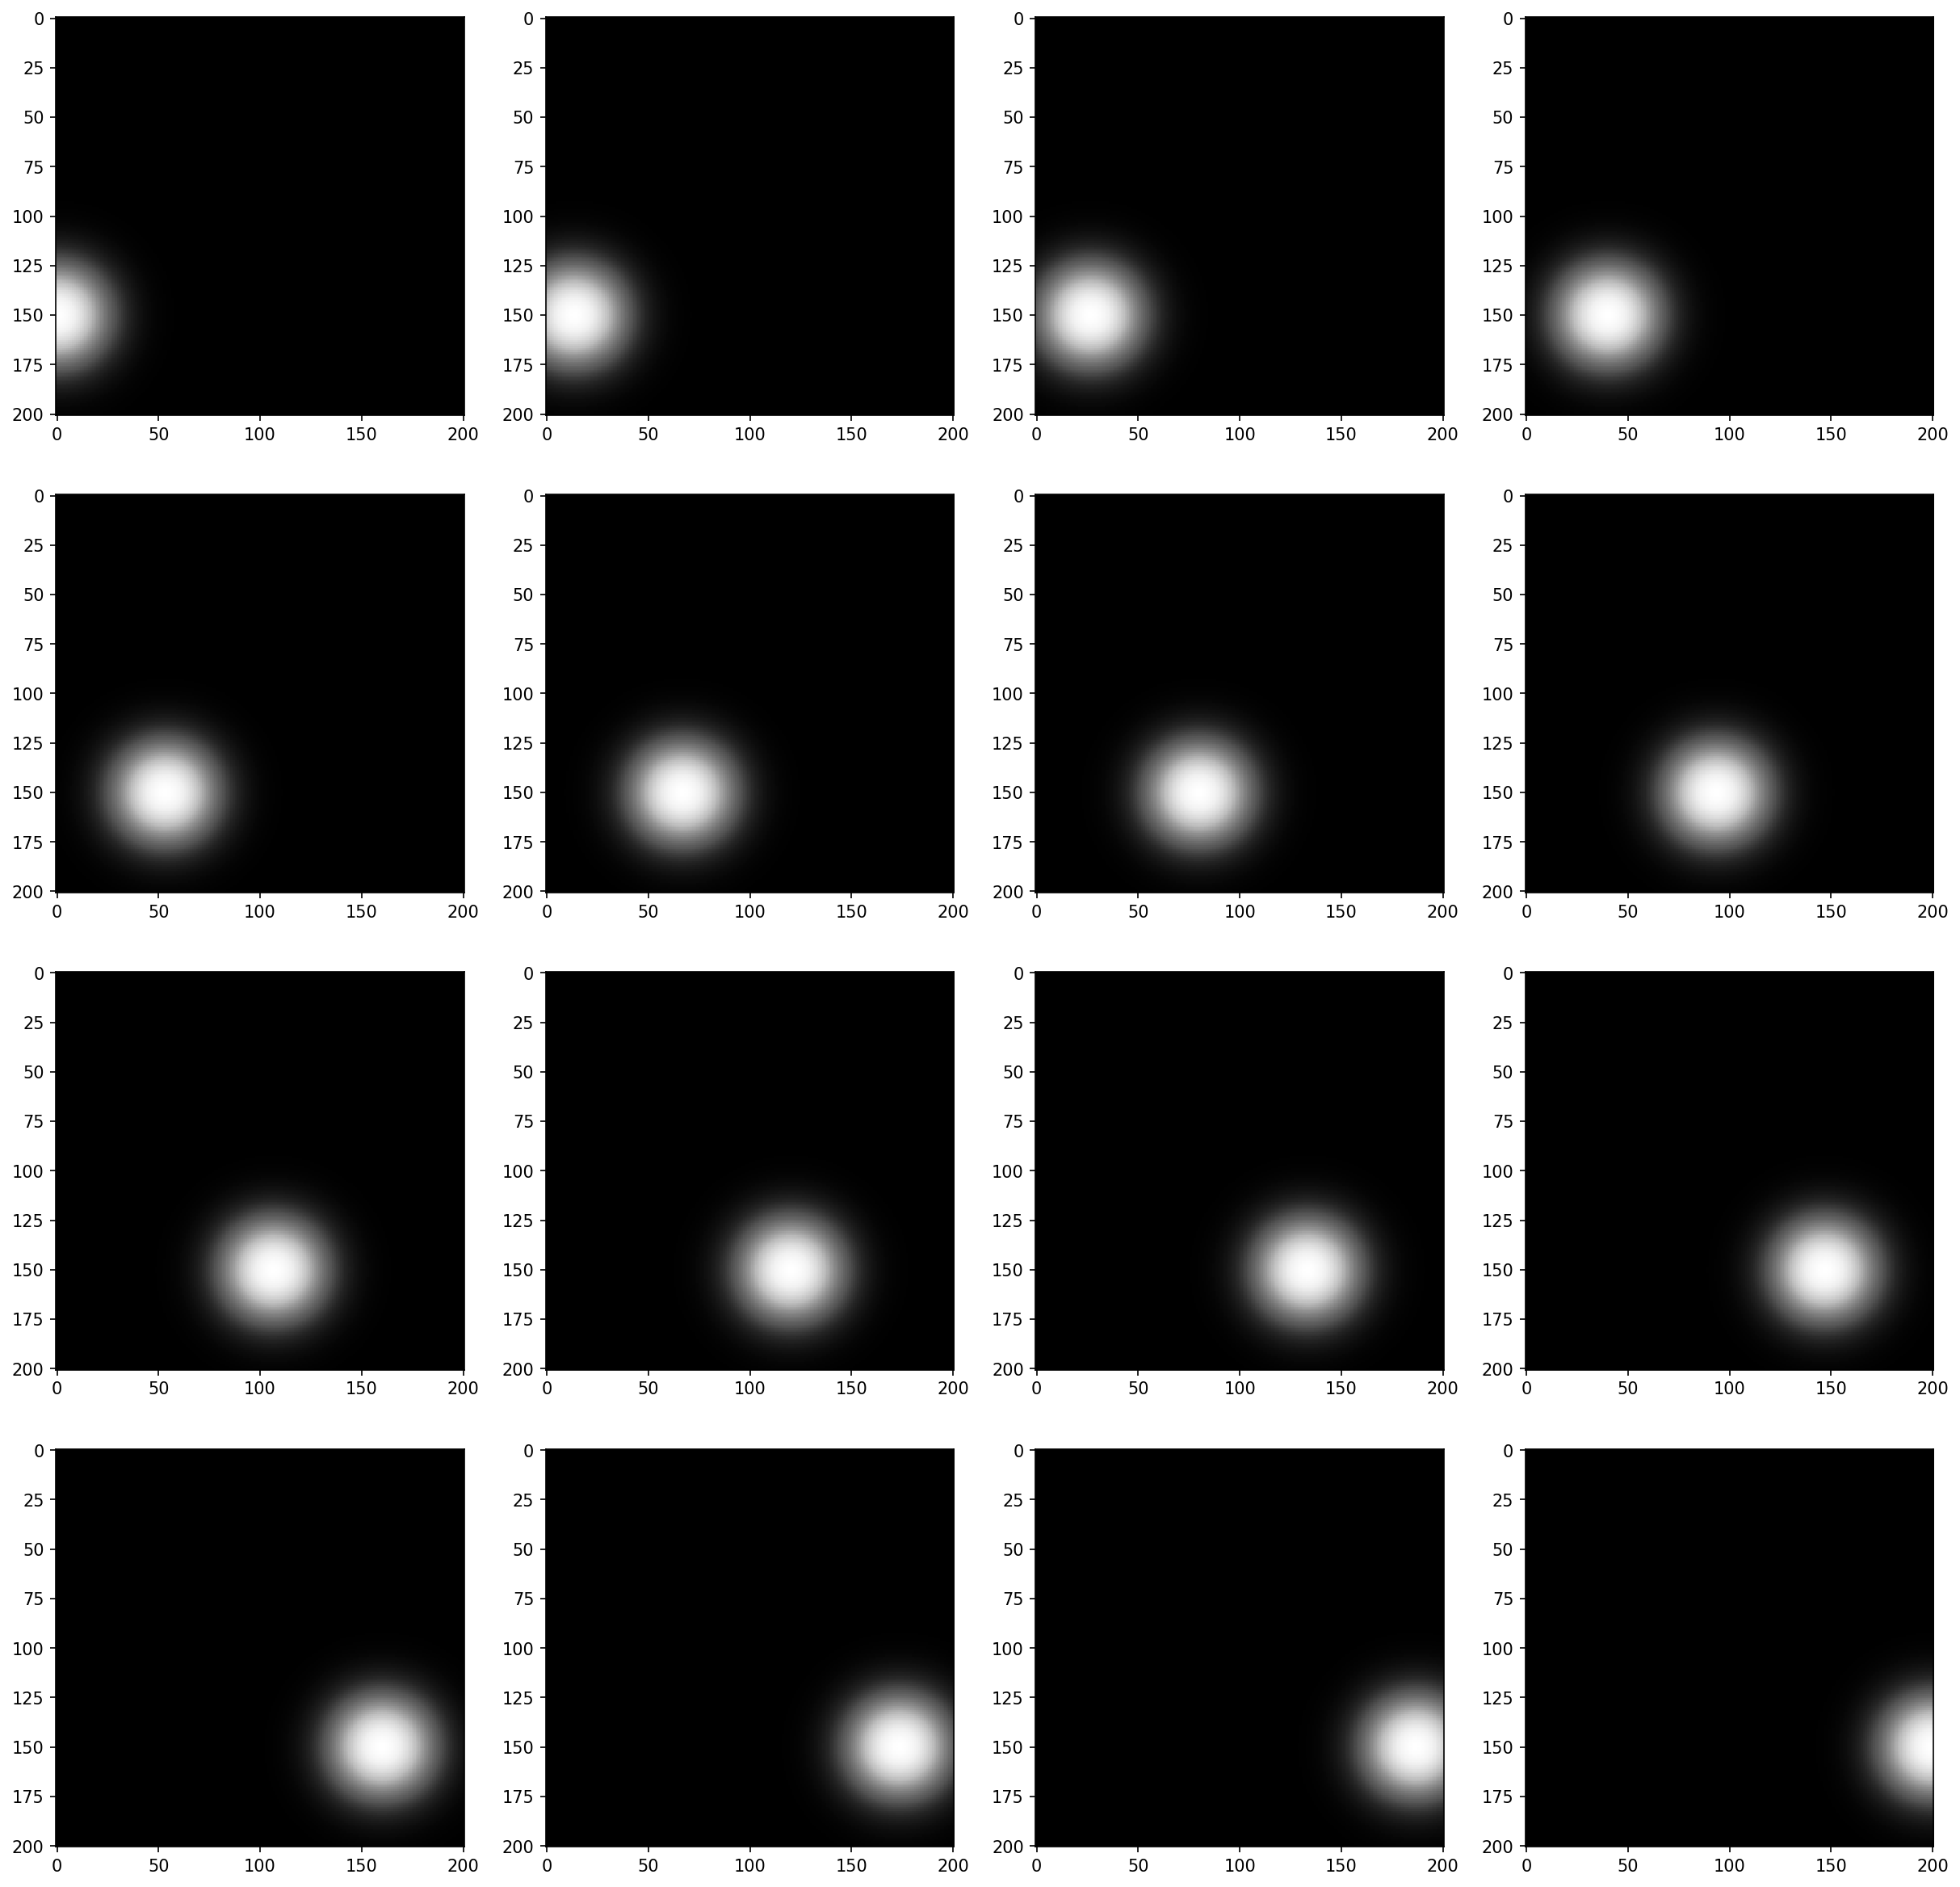

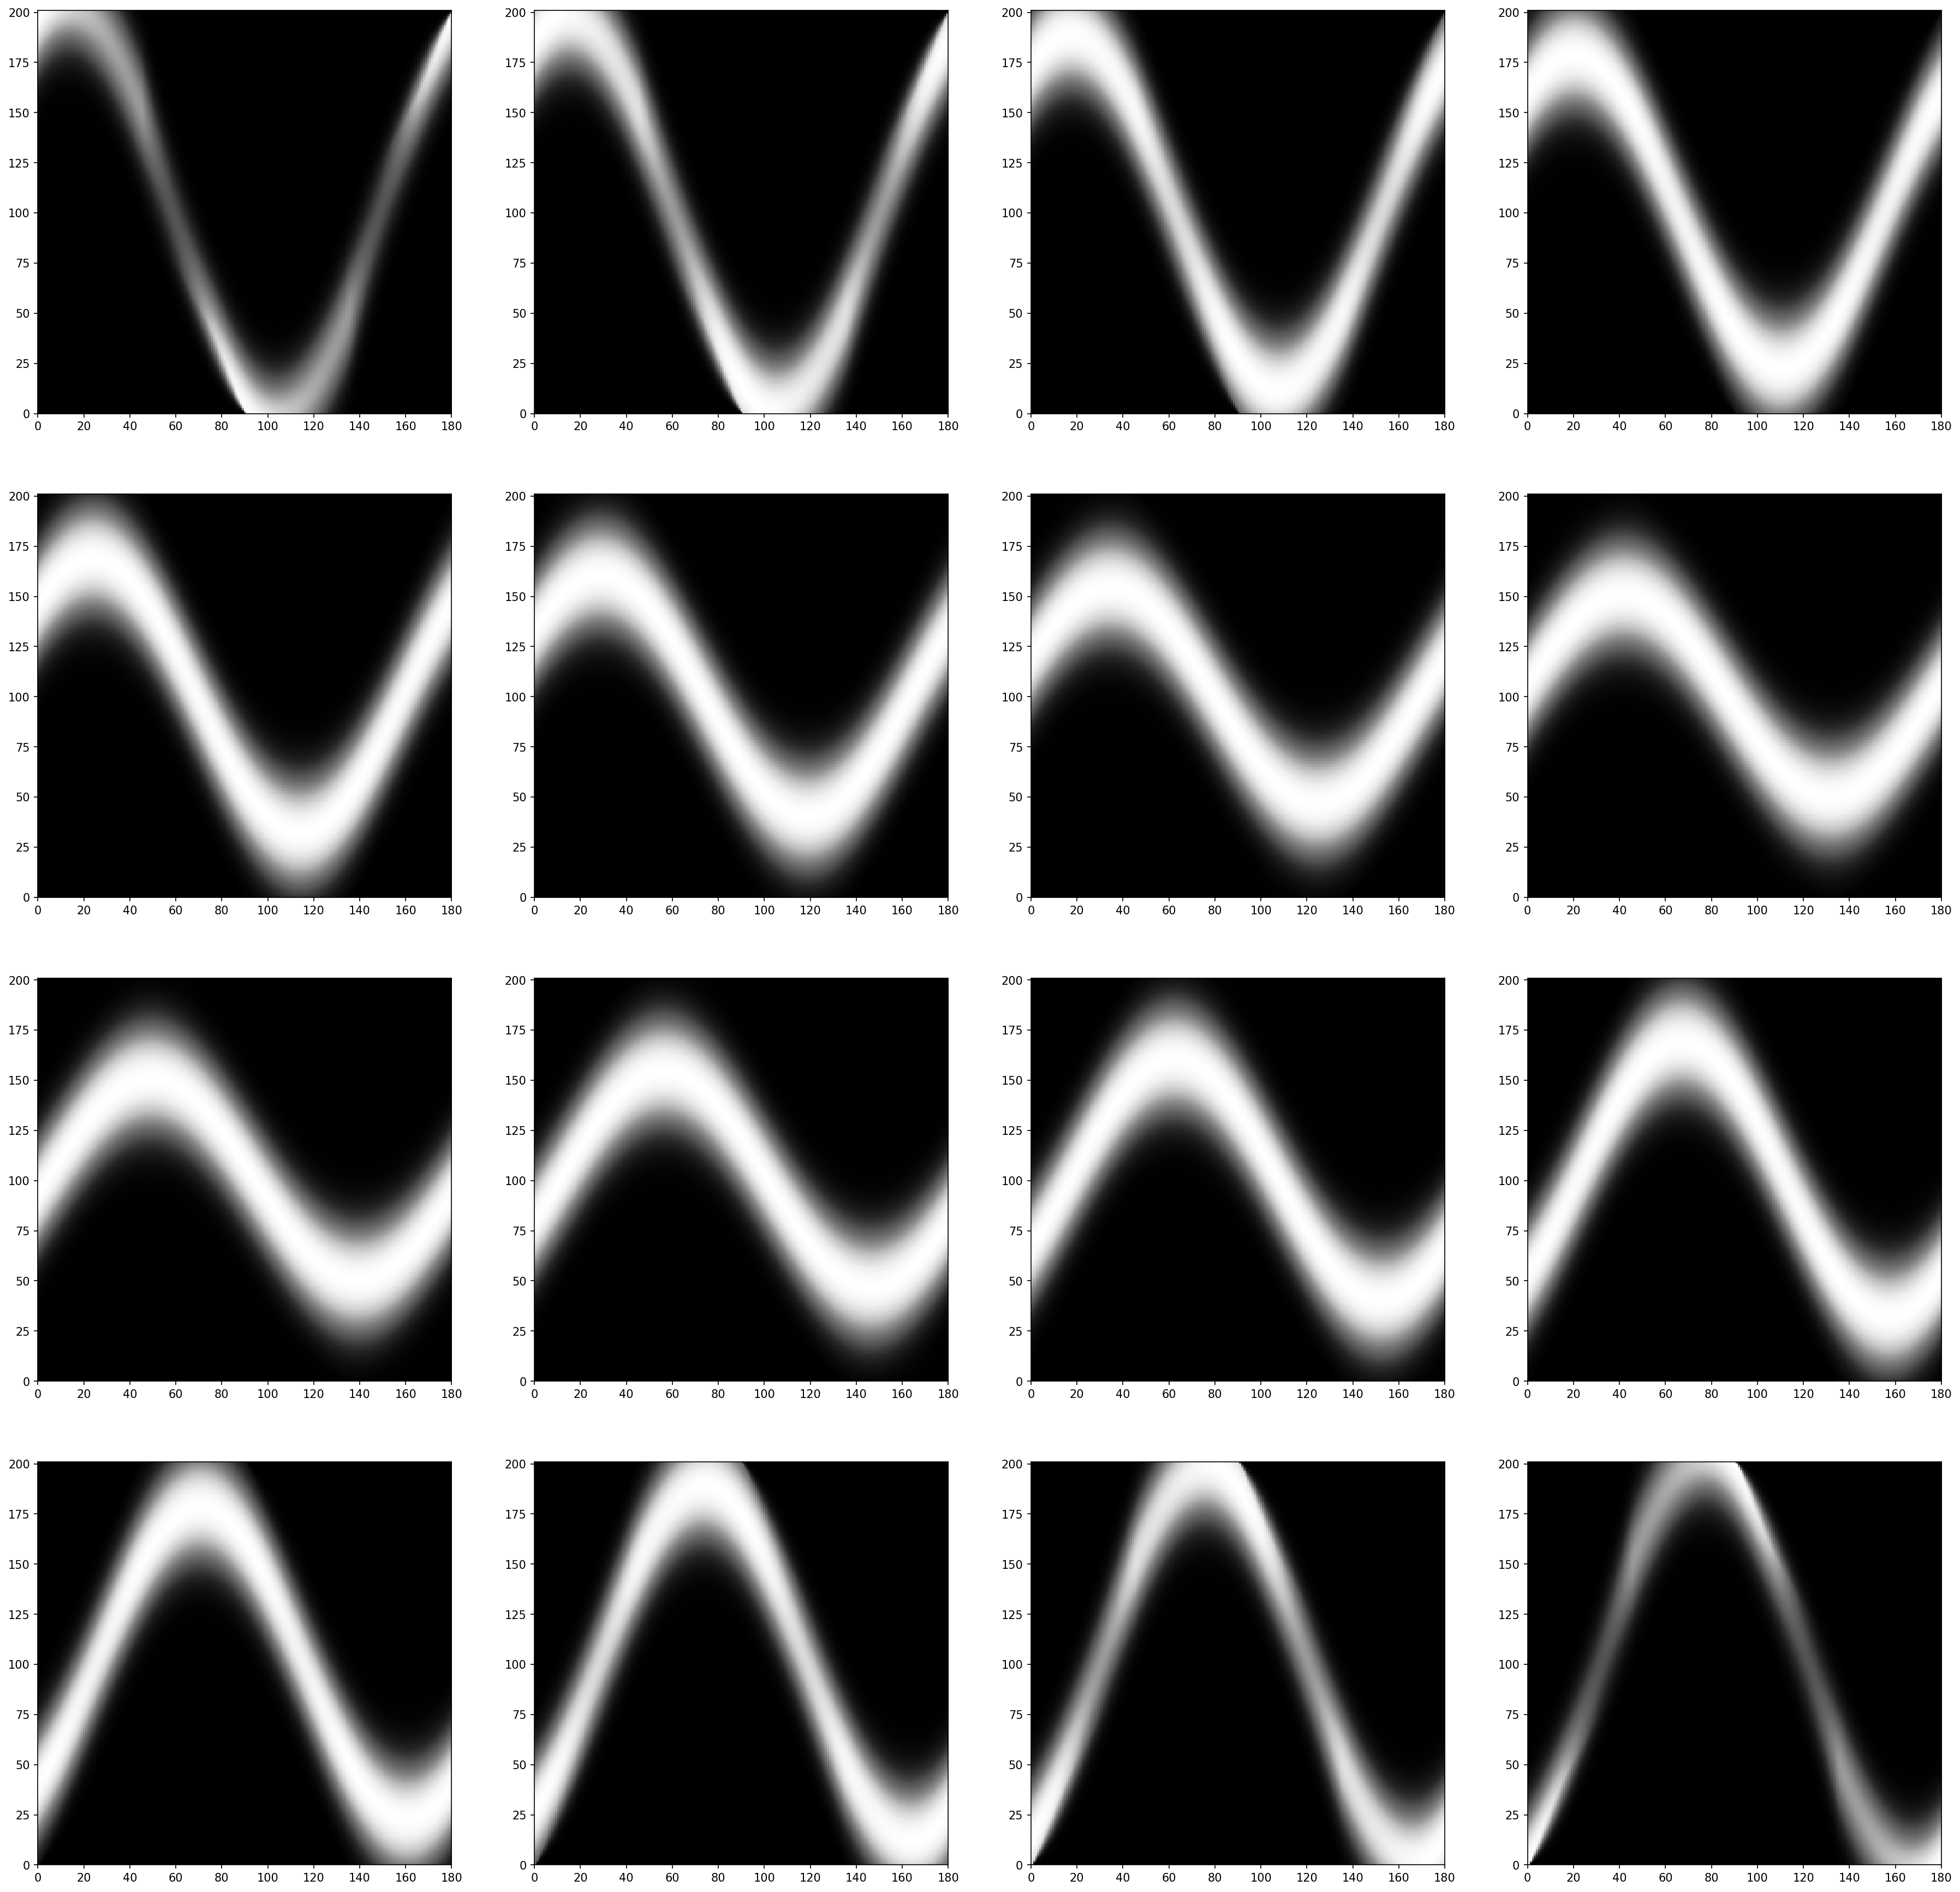

In [19]:
theta = np.linspace(0., 360., max(image.shape), endpoint=False)

fig, axs = plt.subplots(4, 4, figsize=(20,20), dpi=150)
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30), dpi=150)
pos_y =  5
pos_x = np.linspace(-10,10,16)
sig =  3

for i in range(len(pos_x)):
    x = np.linspace(-10, 10, 201)
    y = np.linspace(-10, 10, 201)
    X,Y = np.meshgrid(x,y)
    
    image = np.exp(- ((X-pos_x[i])*(X-pos_x[i]) + (Y-pos_y)*(Y-pos_y)) /(2*sig))
    axs[i//4, i%4].imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    
    sinogram = radon(image, theta=theta, circle=True)
    axs2[i//4, i%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
plt.show()


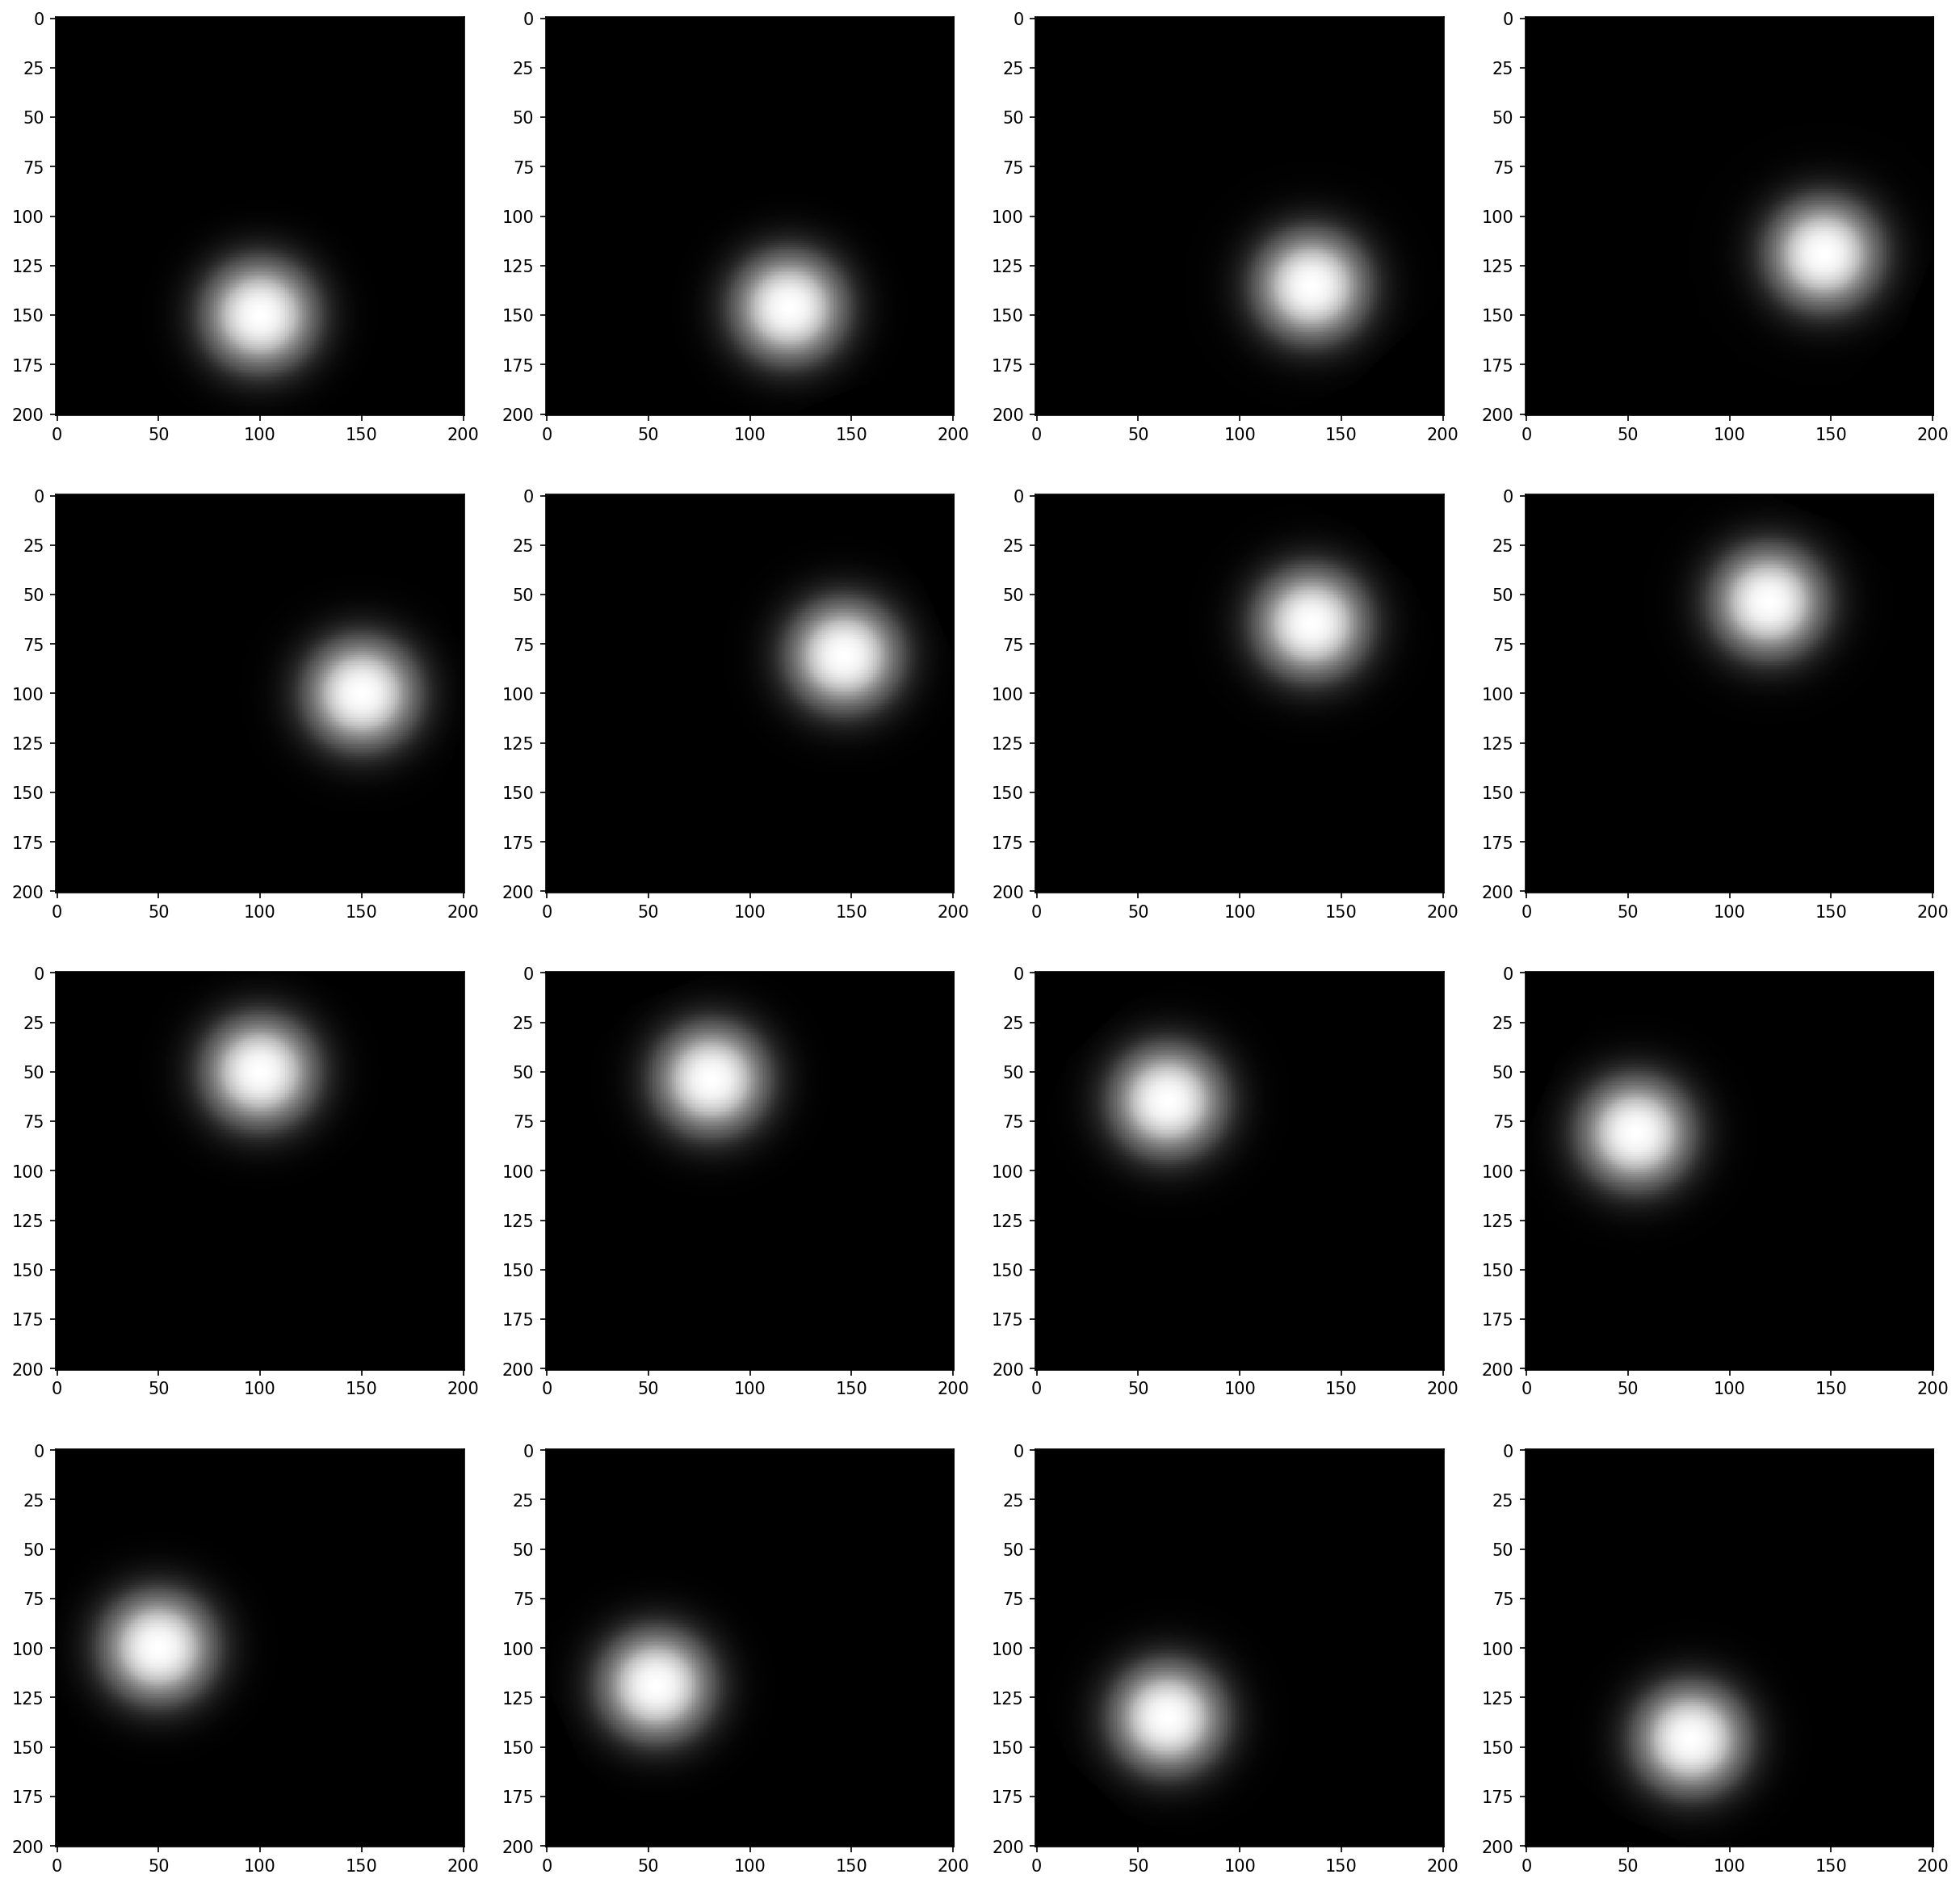

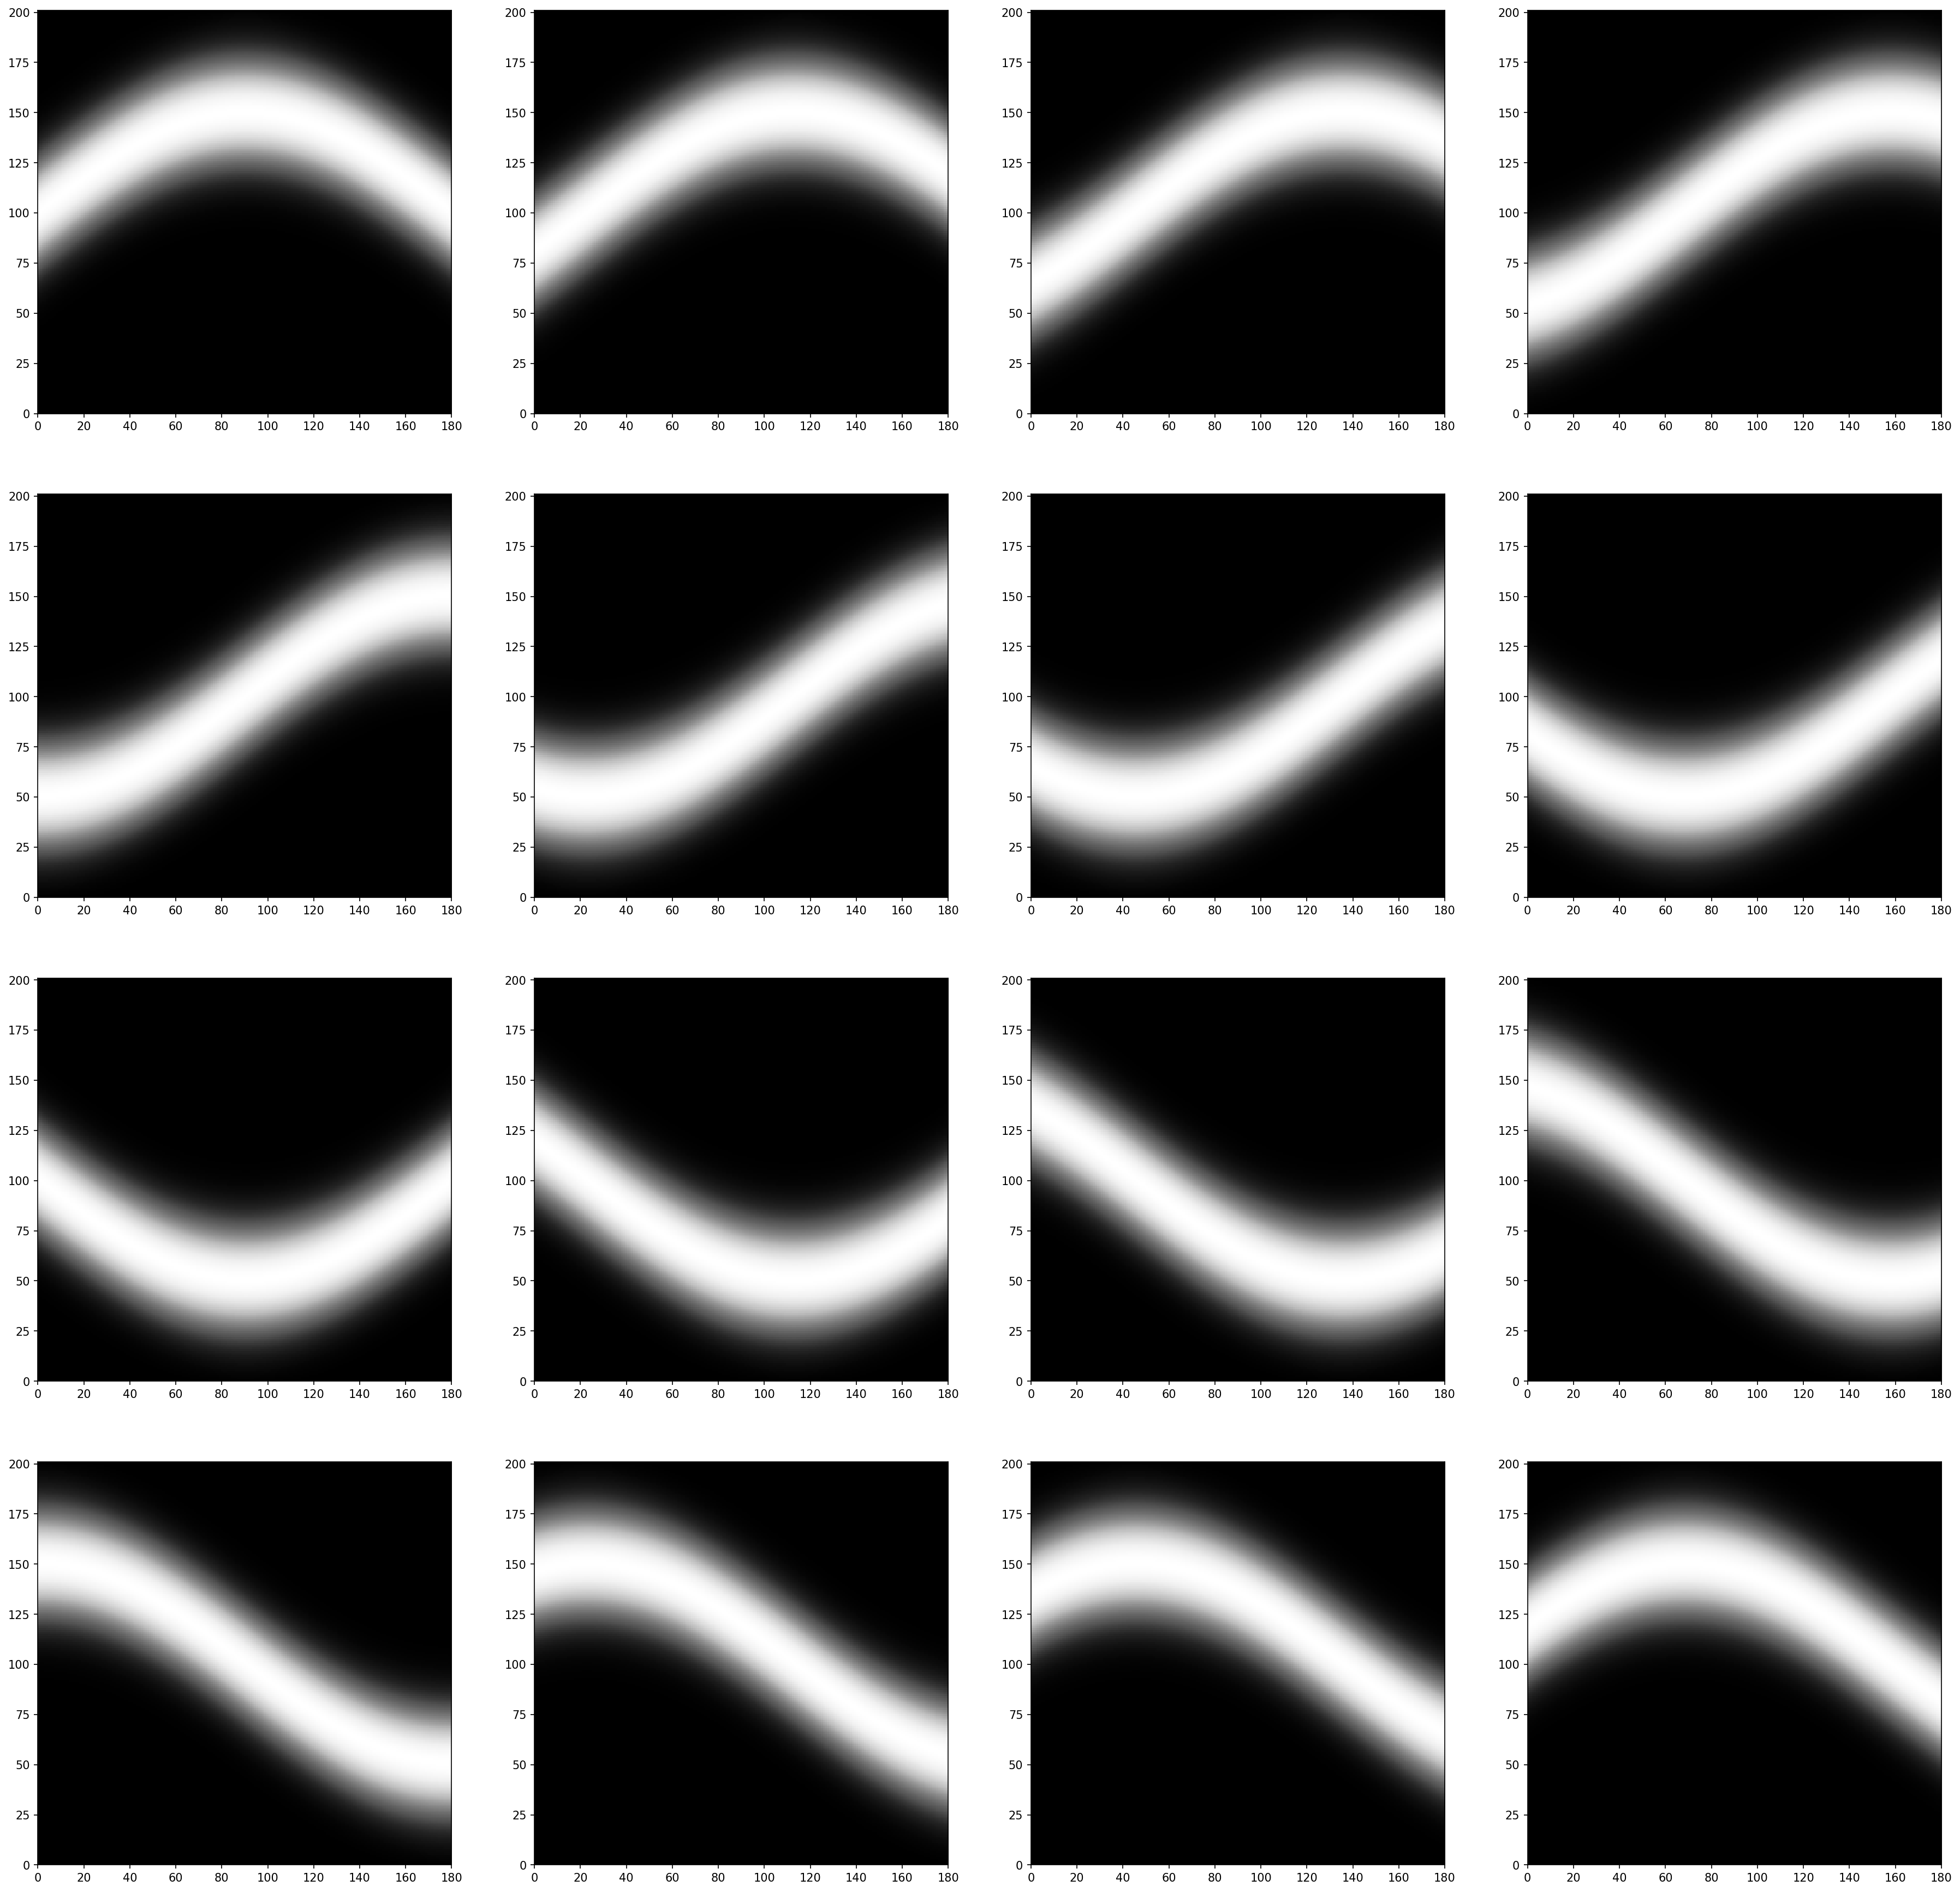

In [32]:
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt
theta = np.linspace(0., 180., max(image.shape), endpoint=False)

fig, axs = plt.subplots(4, 4, figsize=(20,20), dpi=150)
fig2, axs2 = plt.subplots(4, 4, figsize=(30,30), dpi=150)
pos_y =  5
pos_x = 0
sig =  3

x = np.linspace(-10, 10, 201)
y = np.linspace(-10, 10, 201)
X,Y = np.meshgrid(x,y)
image = np.exp(- ((X-pos_x)*(X-pos_x) + (Y-pos_y)*(Y-pos_y)) /(2*sig))

for rot in range(16):
    sinogram = radon(image, theta=theta, circle=True)
    axs[rot//4, rot%4].imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    axs2[rot//4, rot%4].imshow(sinogram, cmap=plt.cm.Greys_r,
                          extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    image = ndimage.rotate(image, 360/16, reshape=False)
    
plt.show()

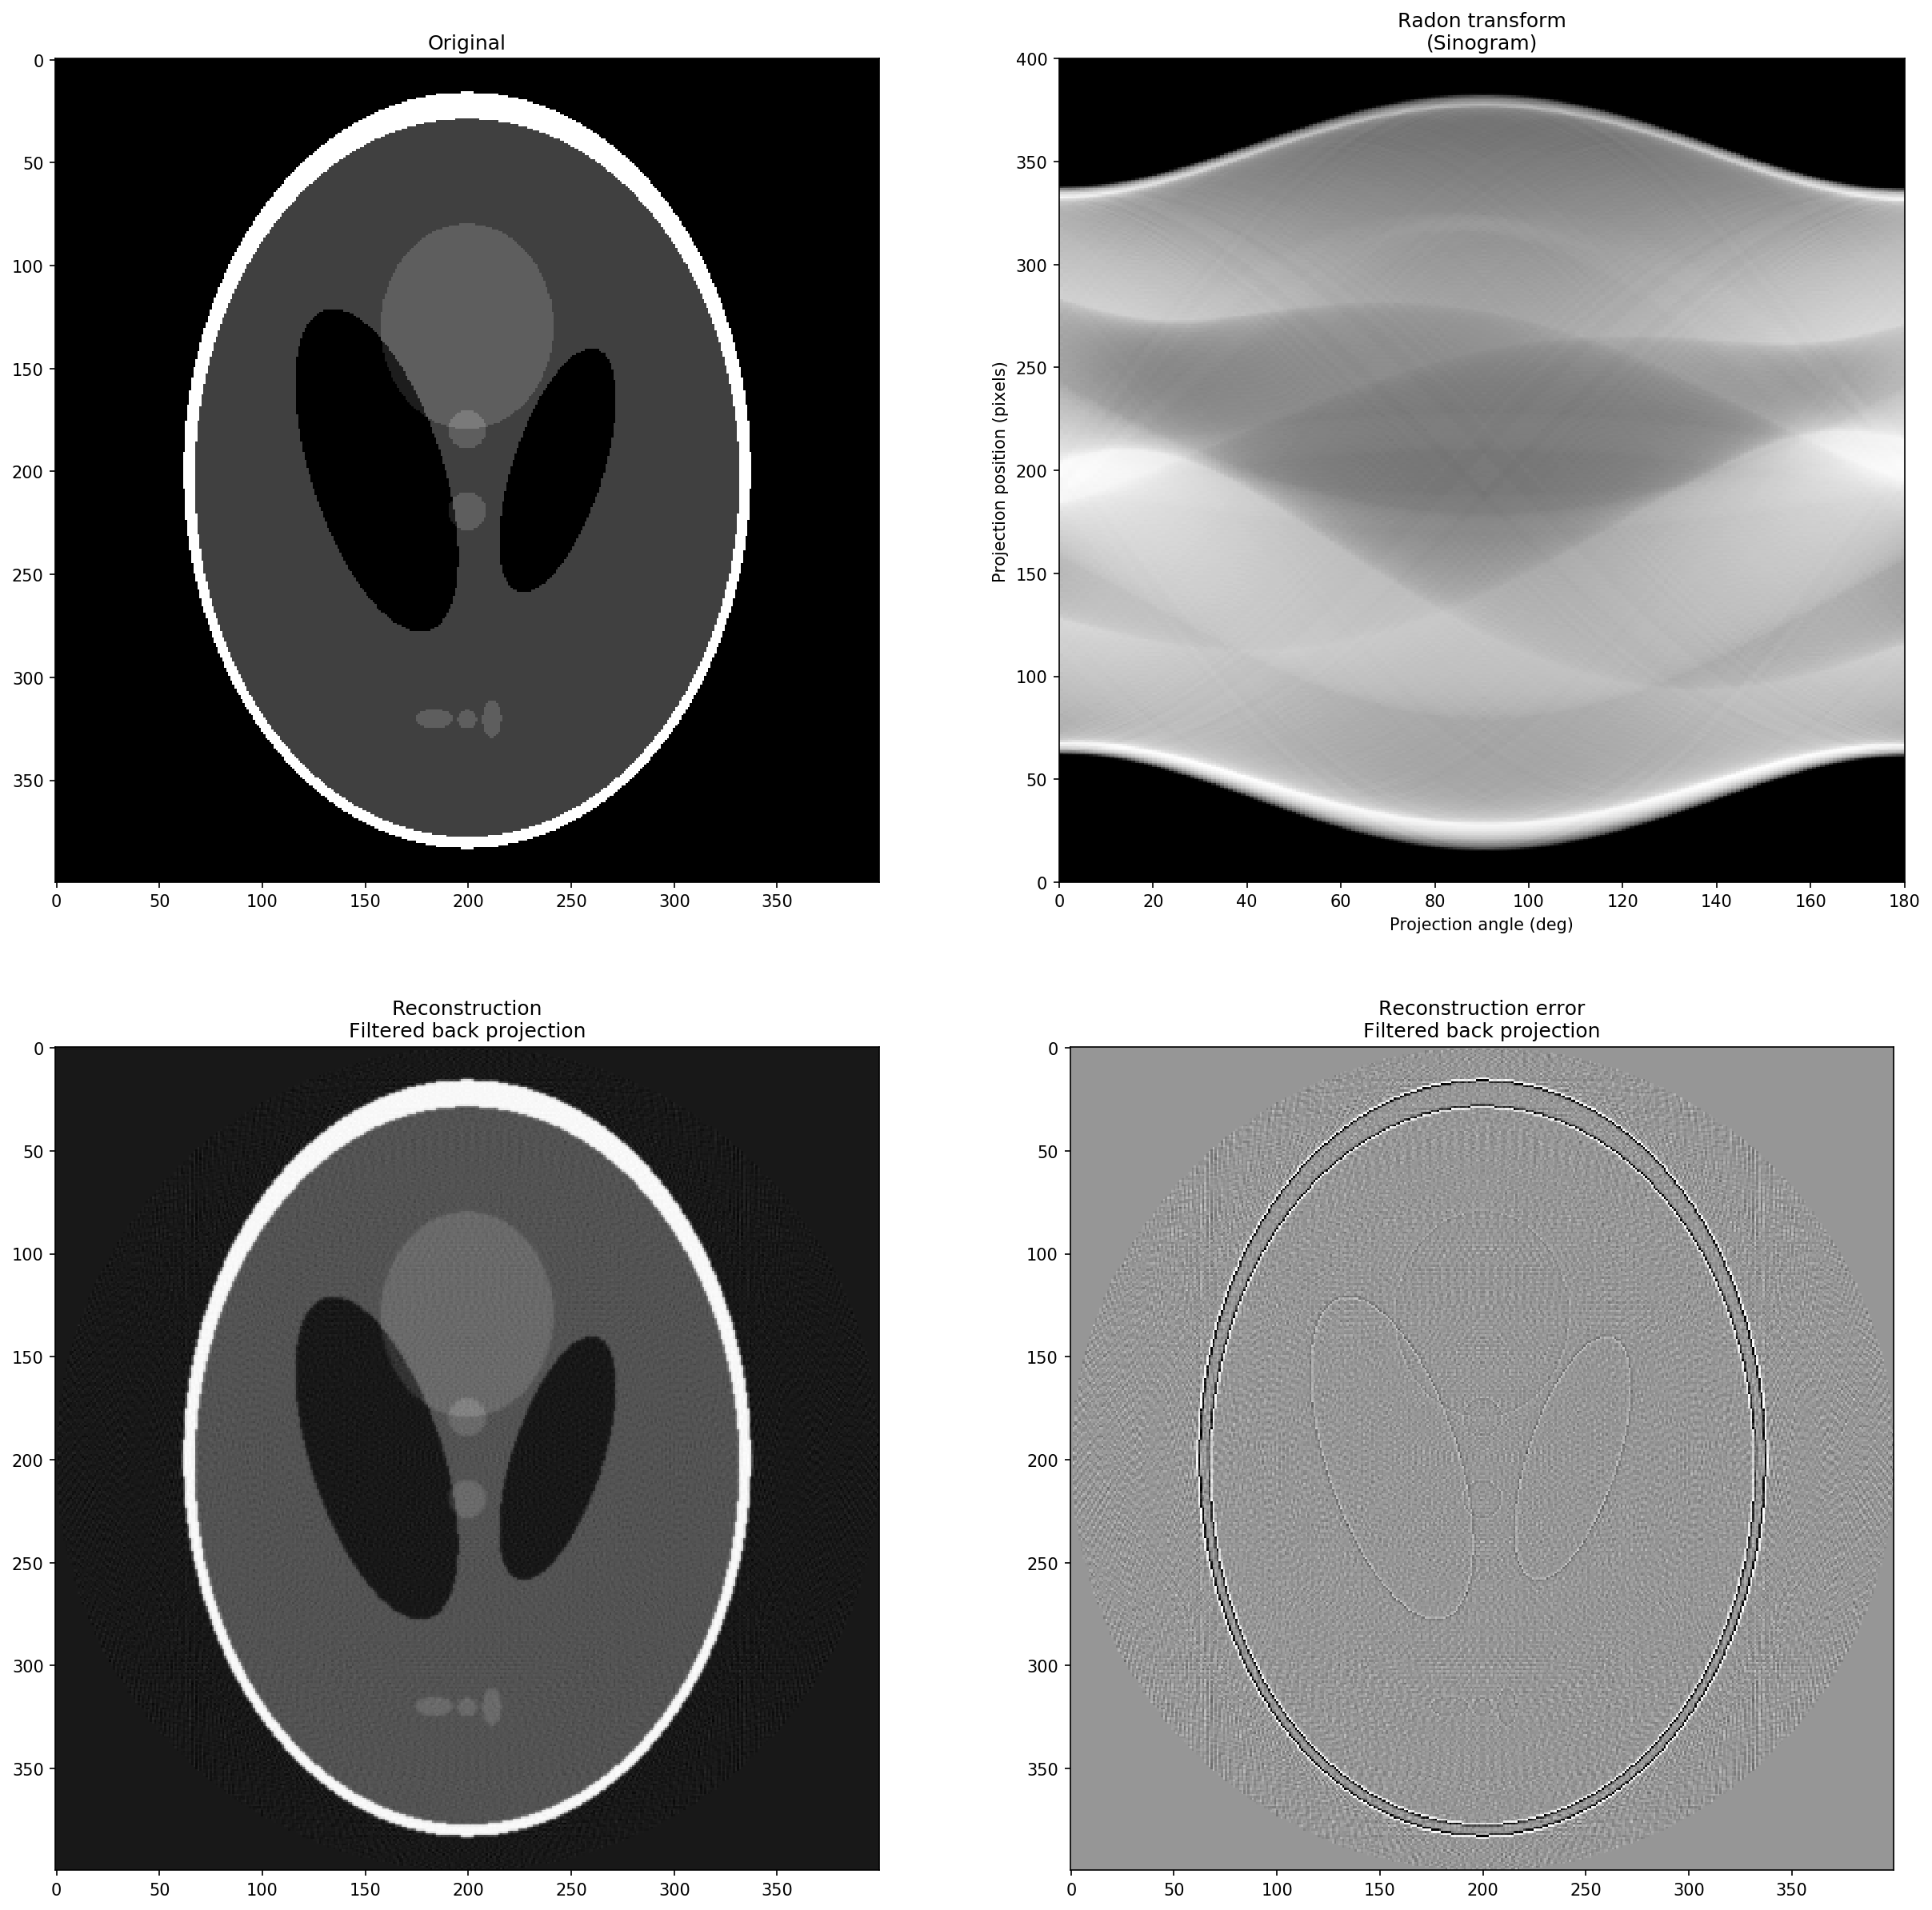

In [4]:
from skimage.transform import iradon, rescale, radon
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

#MODIFY THETA HERE
theta = np.linspace(0., 180., max(image.shape)/2, endpoint=False)
fig, axs = plt.subplots(2,2, figsize=(20,20), dpi=150)

axs[0, 0].set_title("Original")
axs[0, 0].imshow(image, cmap=plt.cm.Greys_r)

sinogram = radon(image, theta=theta, circle=True)
axs[0, 1].set_title("Radon transform\n(Sinogram)")
axs[0, 1].set_xlabel("Projection angle (deg)")
axs[0, 1].set_ylabel("Projection position (pixels)")
axs[0, 1].imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image 

imkwargs = dict(vmin=-0.2, vmax=0.2)

axs[1, 0].set_title("Reconstruction\nFiltered back projection")
axs[1, 0].imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
axs[1, 1].set_title("Reconstruction error\nFiltered back projection")
axs[1, 1].imshow(error, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()


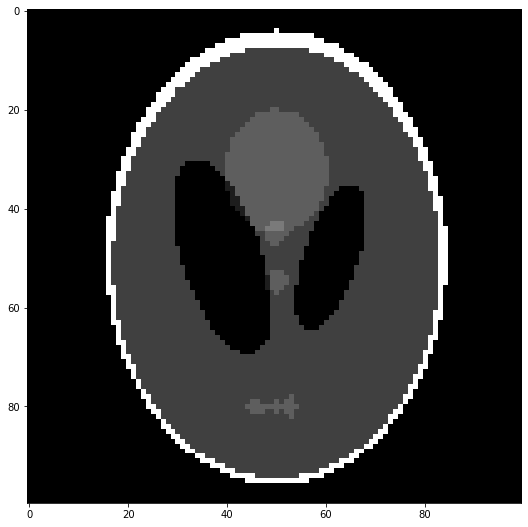

In [13]:
import numpy as np
from skimage.transform import iradon, rescale, radon
from skimage.data import shepp_logan_phantom

step = 4;
image = shepp_logan_phantom()
shape_image = np.shape(image)
shape_sub_sampled = (shape_image[0]//step, shape_image[1]//step)
sub_sampled = np.zeros(shape_sub_sampled)
for i in range(shape_sub_sampled[0]):
    for j in range(shape_sub_sampled[1]):
        sub_sampled[i][j] = image[step * i][step * j]

plt.figure(figsize = (20,20))
plt.subplot(221)
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.subplot(222)
plt.imshow(sub_sampled, cmap=plt.cm.Greys_r)
plt.subplot(223)
#plt.imshow()
#TODO compute radon and iradon

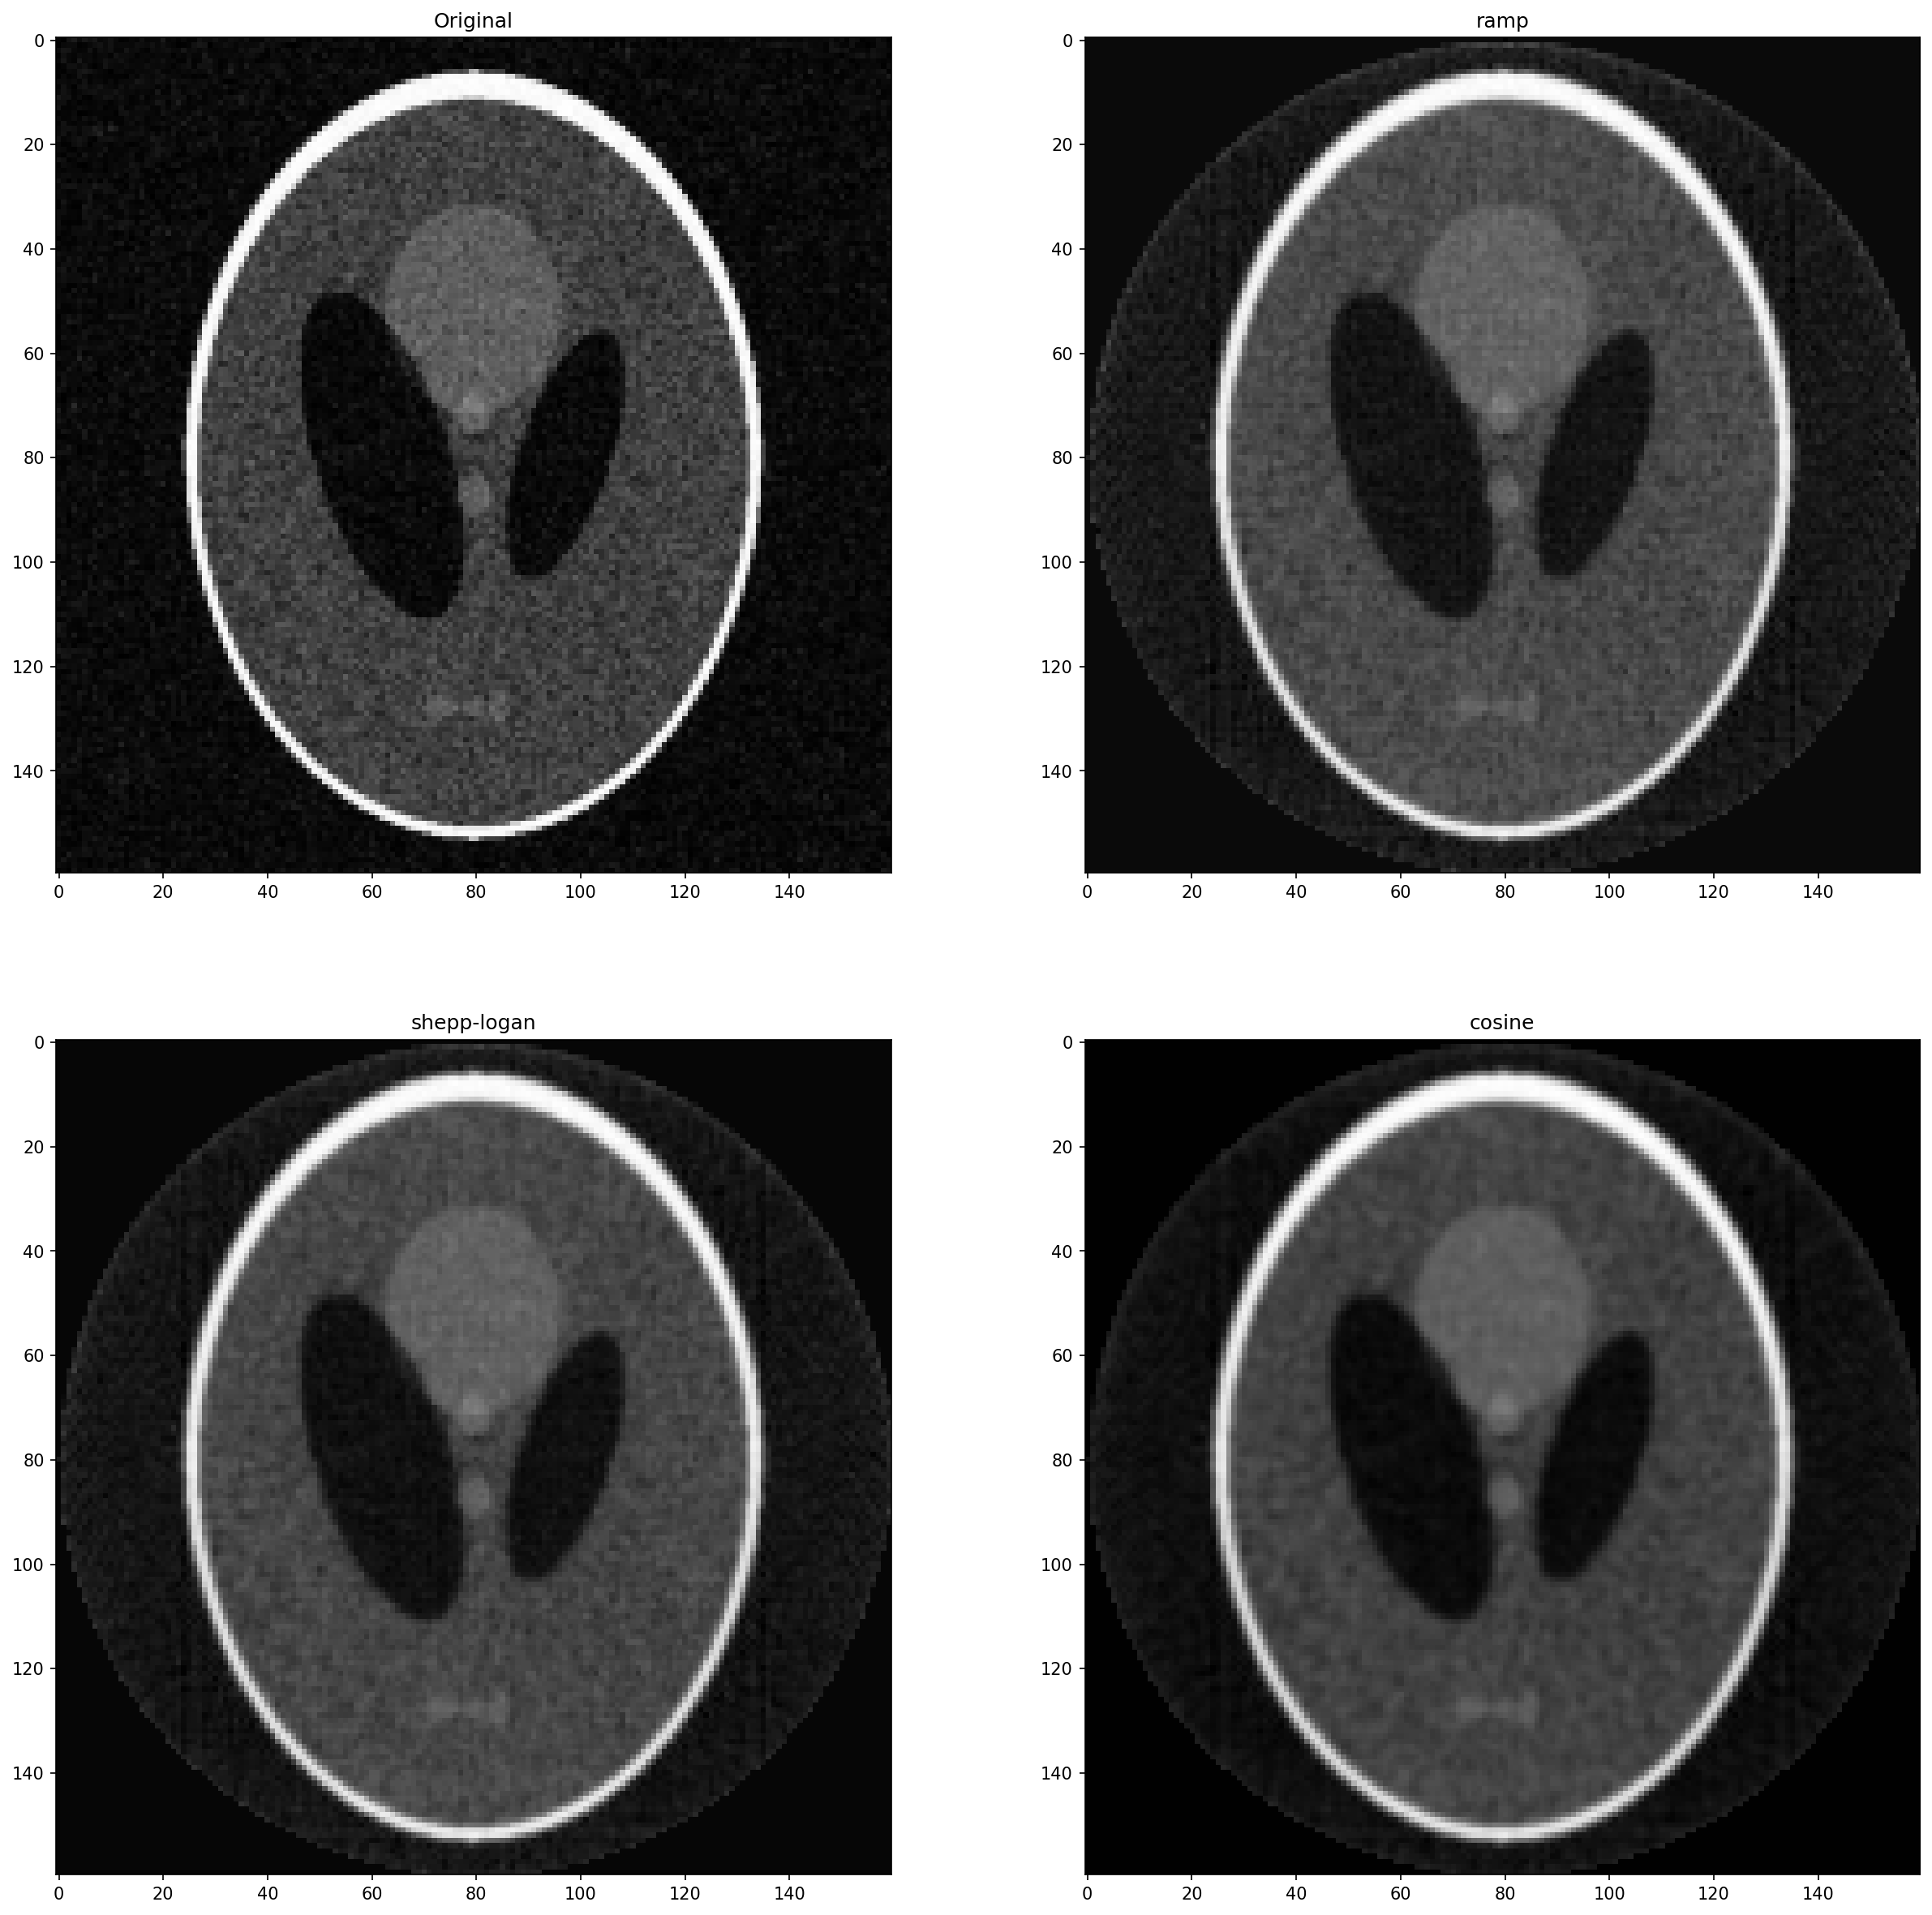

In [5]:
from skimage.transform import iradon, rescale, radon
from skimage.data import shepp_logan_phantom
from skimage.util import random_noise

image = random_noise(shepp_logan_phantom())
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

theta = np.linspace(0.,180., max(image.shape)/2, endpoint=False)
fig, axs = plt.subplots(2,2, figsize=(20,20), dpi=150)

axs[0, 0].set_title("Original")
axs[0, 0].imshow(image, cmap=plt.cm.Greys_r)
sinogram = radon(image, theta=theta, circle=True)




axs[0, 1].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'ramp'), cmap=plt.cm.Greys_r)
axs[0, 1].set_title('ramp')
axs[1, 0].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'shepp-logan'), cmap=plt.cm.Greys_r)
axs[1, 0].set_title('shepp-logan')
axs[1, 1].imshow(iradon(sinogram, theta=theta, circle=True, filter = 'cosine'), cmap=plt.cm.Greys_r)
axs[1, 1].set_title('cosine')
plt.show()